In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


seed = 1337
df = pd.read_csv('input/telco_customer_churn.csv')

# Drop customerID, since it is not related to customer churn.
df.drop(['customerID', ], axis=1, inplace=True) # axis=0 for rows, axis=1 for columns

# Remove white space in columns for later plotting of tree.
df.replace(' ', '_', regex=True, inplace=True)

# Look into the dtype == object columns
for col in df.select_dtypes(include='object'):
    if len(col) < 7:
        tabs = '\t\t\t'
    elif len(col) < 15:
        tabs = '\t\t'
    else:
        tabs = '\t'
    # print(f'{col}:{tabs}{df[col].unique()}')

df.loc[(df['TotalCharges'] == '_'), 'TotalCharges'] = 0.0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

# Let's convert all 'Yes'/'No' columns to 1/0 instead.
cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in cols:
    df[col] = pd.Series(np.where(df[col].values == 'Yes', 1, 0), df.index)
    df[col] = pd.to_numeric(df[col])

# Convert Male / Female to 1 / 0 similar to above.
df['gender'] = pd.Series(np.where(df['gender'].values == 'Male', 1, 0), df.index)
df['gender'] = pd.to_numeric(df['gender'])

# Divide the data into independent variables X and dependent variable y (Churn).
X = df.drop('Churn', axis=1).copy()
y = df['Churn'].copy()

# Convert to one-hot encoding as this is suitable for trees.
# We see that there are a couple of dtype == object columns that are not binary. These, we will one-hot encode.
cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
X_encoded = pd.get_dummies(X, columns=cols)

# Check how many Churn == 1 samples there are compared to total.
print(f'Churn percentage: {round((sum(y) / len(y) * 100), 2)}%')

# Since we only have 26.54% of Churn == 1 samples, we need to use stratification
# when splitting out data into a training and a testing dataset. This way, we
# ensure that the ratio of 1 / 0 will be the same in the training and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=seed, stratify=y)

print(f'Churn percentage train:\t{round((sum(y_train) / len(y_train) * 100), 2)}%')
print(f'Churn percentage test:\t{round((sum(y_test) / len(y_test) * 100), 2)}%\n')

# Optimization round 2 yielded (refer to the hyperparameter_optimization notebook):
print({'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'reg_lambda': 10.0, 'scale_pos_weight': 3})

Churn percentage: 26.54%
Churn percentage train:	26.54%
Churn percentage test:	26.52%

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'reg_lambda': 10.0, 'scale_pos_weight': 3}


In [3]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            missing=None,
                            seed=seed,
                            gamma=0,
                            learn_rate=0.05,
                            max_depth=3,
                            reg_lambda=10,
                            scale_pos_weight=3,
                            subsample=0.9,
                            colsample_bytree=0.5)

clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[23:38:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { learn_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.56009
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.59465
[2]	validation_0-aucpr:0.61201
[3]	validation_0-aucpr:0.63049
[4]	validation_0-aucpr:0.63524
[5]	validation_0-aucpr:0.63658
[6]	validation_0-aucpr:0.64098
[7]	validation_0-aucpr:0.64939
[8]	validation_0-aucpr:0.65236
[9]	validation_0-aucpr:0.65292
[10]	validation_0-aucpr:0.65348
[11]	validation_0-aucpr:0.65636
[12]	validation_0-aucpr:0.65479
[13]	validation_0-aucpr:0.65732
[14]	validation_0-aucpr:0.65962
[15]	validation_0-aucpr:0.66015
[16]	validation_0-aucpr:0.65914
[17]	validation_0-aucpr:0.66023
[18]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learn_rate=0.05, learning_rate=0.300000012, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=1337, reg_alpha=0,
              reg_lambda=10, scale_pos_weight=3, seed=1337, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

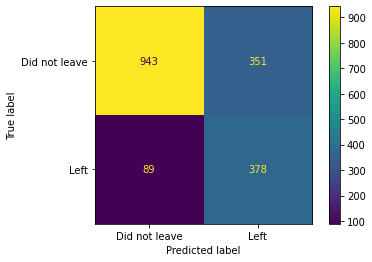

In [4]:
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Did not leave", "Left"])

Before optimization:
- 1187 of those who did not leave were correctly classified (83.47%).
- 107 of those who did not leave were incorrectly classified (31.56%).
- 235 of those who did leave were incorrectly classified (16.53%).
- 232 of those who did leave were correctly classified (68.44%).

After optimization:
- 943 of those who did not leave were correctly classified (72.87%).
- 351 of those who did not leave were incorrectly classified (27.13%).
- 89 of those who did leave were incorrectly classified (19.06%).
- 378 of those who did leave were correctly classified (80.94%).

In conclusion, one can see that we were able to improve the XGBoost model through hyperparameter optimization. Since predicting which customers will leave is much more important from a business perspective than predicting which ones will stay, this is a clear improvement.

In [5]:
# Investigate the tree to gain further info, such as gain and cover, at each node.
# Create just one tree for this purpose by setting n_estimators = 1.
clf_xgb_to_plot = xgb.XGBClassifier(objective='binary:logistic',
                            missing=None,
                            seed=seed,
                            gamma=0,
                            learn_rate=0.05,
                            max_depth=3,
                            reg_lambda=10,
                            scale_pos_weight=3,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            n_estimators=1)

clf_xgb_to_plot.fit(X_train, y_train)

[23:38:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { learn_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learn_rate=0.05, learning_rate=0.300000012, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None,
              monotone_constraints='()', n_estimators=1, n_jobs=0,
              num_parallel_tree=1, random_state=1337, reg_alpha=0,
              reg_lambda=10, scale_pos_weight=3, seed=1337, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [6]:
# Print out weight, gain, cover etc, where
# - weight = number of times a feature is used in a branch or root across all trees,
# - gain = average gain across all splits that the feature is used in,
# - cover = average coverage across all splits the feature is used in,
# - total_gain = total gain across all splits the feature is used in,
# - total_cover = total coverage across all splits the feature is used in.
# In this case, we only built one tree, so the gain = total_gain and cover = total_cover.
bst = clf_xgb_to_plot.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print(f'{importance_type}:\n{bst.get_score(importance_type=importance_type)}\n')

weight:
{'Contract_Month-to-month': 1, 'MonthlyCharges': 1, 'TotalCharges': 1, 'InternetService_Fiber_optic': 1, 'tenure': 2}

gain:
{'Contract_Month-to-month': 1682.23706, 'MonthlyCharges': 122.327515, 'TotalCharges': 36.9853096, 'InternetService_Fiber_optic': 243.940857, 'tenure': 143.3522875}

cover:
{'Contract_Month-to-month': 1816.75, 'MonthlyCharges': 591.5, 'TotalCharges': 171.5, 'InternetService_Fiber_optic': 1225.25, 'tenure': 612.625}

total_gain:
{'Contract_Month-to-month': 1682.23706, 'MonthlyCharges': 122.327515, 'TotalCharges': 36.9853096, 'InternetService_Fiber_optic': 243.940857, 'tenure': 286.704575}

total_cover:
{'Contract_Month-to-month': 1816.75, 'MonthlyCharges': 591.5, 'TotalCharges': 171.5, 'InternetService_Fiber_optic': 1225.25, 'tenure': 1225.25}



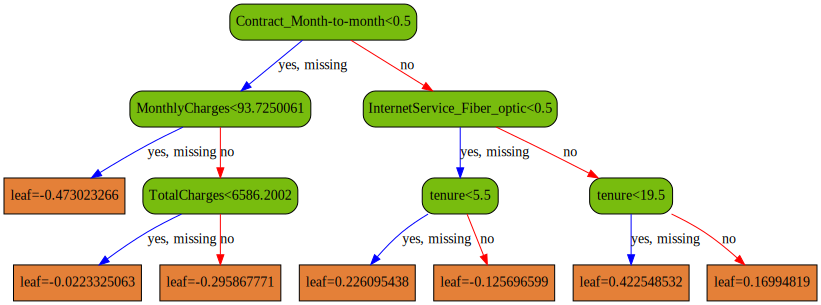

In [7]:
# Make the tree look better.
node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78bce'}
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

# Here, num_trees is not the number of trees to plot; it is the number of the specific tree you wish to plot.
# Had to run 'sudo pacman -S graphviz' on Manjaro and 'brew install graphviz' on Mac to get this to work.
xgb.to_graphviz(clf_xgb_to_plot,
                num_trees=0,
                size='10,10',
                condition_node_params=node_params,
                leaf_node_params=leaf_params)